## Imports

In [73]:
import scipy.io
from tqdm import tqdm
import numpy as np
import math
from sklearn import linear_model 
from scipy import linalg
from sklearn import preprocessing as preproc # load preprocessing function
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from sklearn.model_selection import KFold

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set_theme() # Set searborn as default

## Load dataset

In [7]:
mat = scipy.io.loadmat('sand.mat')

X = mat['X']
y = mat['Y']

[n,p] = X.shape
n,p

(59, 2016)

### 1 Apply Least angle regression and selection (LARS) for the $p \gg n$ sand data set (X: data matrix with 59 observations and 2016 features, y: the measured moisture content in percent for each sand sample). Find a suitable solution using:

>(a) The Cp statistic. Consider whether the Cp-statistic makes sense in this case (p > n). Why? Why not?

>> (i) Hint: What happens to your estimate of the noise in the data?

In [69]:
# Estimate the noise of the data
# Calculate an unbiased OLS estimate using linalg.lstsq
sol, residuals, rank, s_sol = linalg.lstsq(X, y)
y_hat = X @ sol
sigma2 = np.sum((y - y_hat)**2)/(n-p)
sigma2


np.float64(-3.4165699885274603e-26)

>(b) Using Cross-validation. Remember to center y and normalize X, but do it inside
the cross validation!

In [ ]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu


def normalize(data):

    mu = np.mean(data, axis=0)
    sd = np.std(data, axis=0)

    data = (data - mu)/sd
    return data, mu, sd


# Set up cross validation like you did last week
CV = 5 # if K = n leave-one-out, you may try different numbers
kf = KFold(n_splits=CV)

# Set a suitable range of features that can be given to LARS as n_nonzero_coefs 
stop = n-math.ceil(n/CV)
K = range(stop)

Err_tr  = np.zeros((CV, len(K)))
Err_tst = np.zeros((CV, len(K))) 
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.
    X_train, y_train = X[train_index], y[train_index]
    X_train, X_train_mu, X_train_sd = normalize(X_train)
    y_train, y_train_mu = centerData(y_train)

    X_test, y_test = X[test_index], y[test_index]
    X_test = (X_test - X_train_mu)/X_train_sd
    y_test = y_test - y_train_mu

    # compute all LARS solutions inside each fold 
    for j in K:
        model = linear_model.Lars(n_nonzero_coefs=j+1, fit_path = False, fit_intercept = False, verbose = True)
        model.fit(X_train, y_train)

        y_train_hat = model.predict(X_train)
        y_test_hat = model.predict(X_test)

        Err_tr[i, j] = np.mean((y_train_hat - y_train.ravel())**2)
        Err_tst[i, j] = np.mean((y_test_hat - y_test.ravel())**2)


err_tr = np.mean(Err_tr, axis=0) # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0) # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(CV) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation

In [ ]:
# Compute Cp-statistic, assumption n > p

# run LARS on all data and and vary the nonzero coefs from 0 to p. save the betas for Cp
betas = np.zeros((n, p))
for i in tqdm(range(n)):
    reg = linear_model.Lars(n_nonzero_coefs=i+1, fit_path = False, fit_intercept = False, verbose = True)
    reg.fit(X,y)
    if betas[i,:].shape != reg.coef_.ravel().shape:
        print(betas[i,:].shape, reg.coef_.ravel().shape)
    betas[i,:] = reg.coef_.ravel()

Cp = 


100%|██████████| 59/59 [00:00<00:00, 145.09it/s]


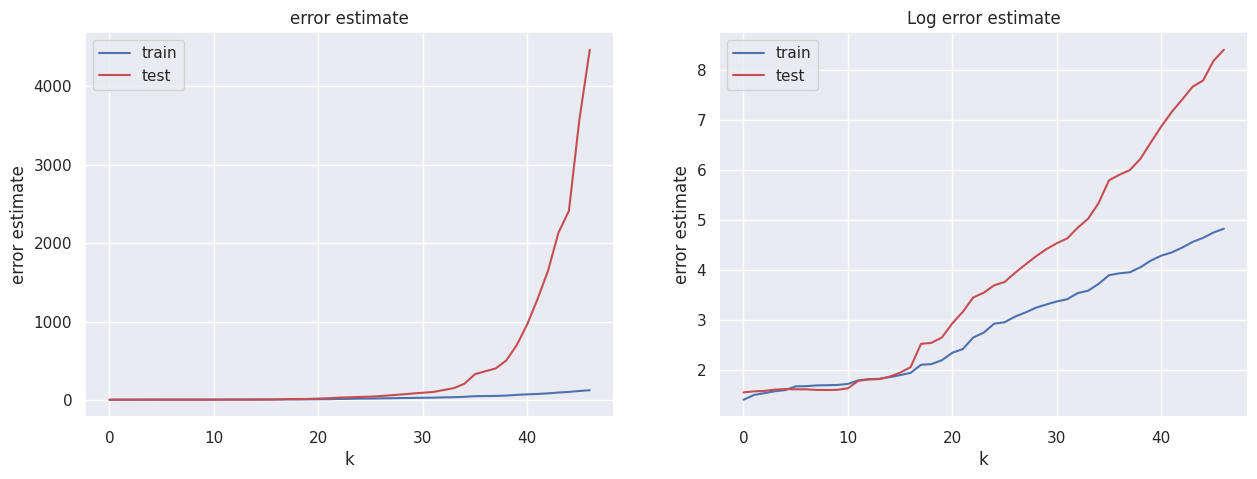

In [96]:
fig, ax = plt.subplots(1,2, figsize=(15,5))    
ax[0].plot(K, err_tr, 'b', label='train')
ax[0].plot(K, err_tst, 'r', label='test')
#ax[0].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('error estimate')
ax[0].set_title("error estimate")

ax[1].plot(K, np.log(err_tr), 'b', label='train')
ax[1].plot(K, np.log(err_tst), 'r', label='test')
#ax[1].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].set_ylabel('error estimate')
ax[1].set_title("Log error estimate")
plt.show()